In [59]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from connector import tableau_db_params
from datetime import datetime, timedelta
import os
from docxtpl import DocxTemplate,InlineImage
from docx.shared import Cm
from dotenv import load_dotenv
load_dotenv()


True

In [61]:
file_queries = os.getenv('REPORT_SERVICE')

# Load environment variables from the .env file

month = datetime.now().month 
year = datetime.now().year
api_params = {'month': '09', 'year': '2023'}

def get_first_and_last_day_of_month(year, month):
    first_day = datetime(year, month, 1)
    last_day = datetime(year, month + 1, 1) - timedelta(days=1)
    
    return first_day.strftime('%Y-%m-%d'), last_day.strftime('%Y-%m-%d')

# Example for September 2023
first_day, last_day = get_first_and_last_day_of_month(year, month)

In [85]:
pg_conn = psycopg2.connect(**tableau_db_params)

# line chart (╯ ͡❛ ͜ʖ ͡❛)╯┻━┻

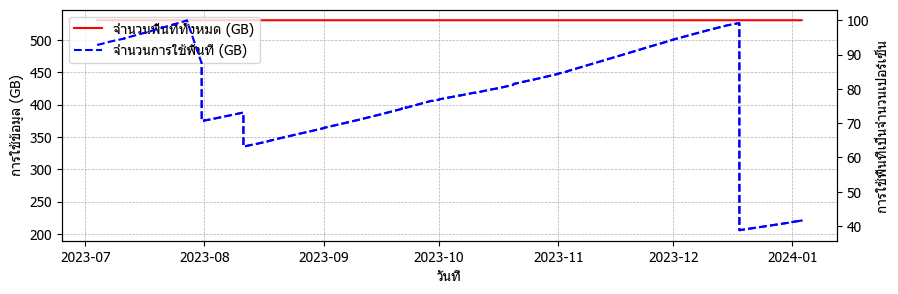

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import requests
from urllib.parse import urlparse, parse_qs

url = os.getenv('REPORT_SERVICE')+f"tableau/disk_lineplot_Usage?month={month}&year={year}"  #"http://localhost:1234/report-service/api/v1/tableau/Disk_lineplot_Usage?month=11&year=2023"
auth_token = os.getenv('AUTH_TOKEN')
# แยกพารามิเตอร์จาก URL
parsed_url = urlparse(url)

# ดึงค่าเดือนจากพารามิเตอร์
is_month = int(parse_qs(parsed_url.query).get('month', [])[0])

# Add Bearer token to the request headers
headers = {
    'Authorization': f'{auth_token}',  # Replace '1234' with your actual token
}

# Fetch JSON data from the URL with headers
response = requests.get(url, headers=headers)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    json_data = response.json()
    
    # Extract the 'data' key from the JSON data
    data_list1 = json_data.get('total_runs', {}).get('data', [])

    # Create a DataFrame from the list of dictionaries
    disk_df = pd.DataFrame(data_list1)
    
    # Now you can use the DataFrame 'disk_df' for further analysis or visualization
else:
    print(f"Error: {response.status_code}")
def bytes_to_gb(bytes):
    gb = bytes / (1024 ** 3)
    return gb

disk_df['total_space_gb'] = disk_df['total_space_bytes'].map(bytes_to_gb)
disk_df['used_space_gb'] = disk_df['used_space_bytes'].map(bytes_to_gb)

disk_df['record_timestamp'] = pd.to_datetime(disk_df['record_timestamp'])
disk_df = disk_df.sort_values('record_timestamp')

# Check if the month is October
is_october = disk_df['record_timestamp'].dt.month == is_month

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 3))

# Plot the total space on the first axis
ax1.plot(disk_df['record_timestamp'], disk_df['total_space_gb'], 'r', label='จำนวนพื้นที่ทั้งหมด (GB)')

# Plot the used space on the first axis
ax1.plot(disk_df['record_timestamp'], disk_df['used_space_gb'], 'b--', label='จำนวนการใช้พื้นที่ (GB)')

ax1.set_xlabel('วันที่')
ax1.set_ylabel('การใช้ข้อมูล (GB)')

# Create a secondary axis for the percentage
ax2 = ax1.twinx()
plt.rcParams['font.family'] = 'Tahoma'

# Calculate the used space percentage
used_space_percentage = (disk_df['used_space_bytes'] / disk_df['total_space_bytes']) * 100

# Plot the used space percentage on the secondary axis
if is_october.any():
    ax2.plot(disk_df[is_october]['record_timestamp'], used_space_percentage[is_october], 'b')
if (~is_october).any():
    ax2.plot(disk_df[~is_october]['record_timestamp'], used_space_percentage[~is_october], 'b--')

ax2.set_ylabel('การใช้พื้นที่เป็นจำนวนเปอร์เซ็น')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc='upper left')

ax1.set_axisbelow(True)
ax1.grid(linestyle='--', linewidth=0.5)

img_path = 'Tableau_Server_Disk_Space'
plt.savefig(img_path,bbox_inches='tight')
plt.show()

# performace bar (╯ ͡❛ ͜ʖ ͡❛)╯┻━┻

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Specify the URL to fetch JSON data
url = os.getenv('REPORT_SERVICE')+f"tableau/tableau/get_performace?month={month}&year={year}" #"http://localhost:1234/report-service/api/v1/tableau/Get_Performace_Dashboard?month=12&year=2023"
auth_token = os.getenv('AUTH_TOKEN')
# Add Bearer token to the request headers
headers = {
    'Authorization': f'{auth_token}',  # Replace '1234' with your actual token
}

# Fetch JSON data from the URL with headers
response = requests.get(url, headers=headers)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    json_data = response.json()
    
    # Extract the 'data' key from the JSON data
    data_list1 = json_data.get('total_runs', {}).get('data', [])

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data_list1)

# Assuming you have a DataFrame called 'data' with the provided data

# Calculate the IQR (Interquartile Range) for elapsed_time_sec
Q1 = df['elapsed_time_sec'].quantile(0.25)
Q3 = df['elapsed_time_sec'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to remove outliers
filtered_data = df
plt.rcParams['font.family'] = 'Tahoma'

# Sort the View Names by count of data points (records)
sorted_view_names = filtered_data['name'].value_counts().head(10).index

# Create a boxplot for each View Name and stack them together
fig, ax = plt.subplots(figsize=(15, 8))
boxplot_data = [filtered_data[filtered_data['name'] == view_name]['elapsed_time_sec'] for view_name in sorted_view_names]

# Set the boxplot colors
default_color = '#7ED957'
colors = [default_color if view_name != 'รายงานวิเคราะห์ข้อมูลท่อรั่วราย DMA' else '#FF3131' for view_name in sorted_view_names]

bp = ax.boxplot(boxplot_data, vert=False, labels=sorted_view_names, showfliers=False, patch_artist=True)

# Loop through the boxplots to set the box colors
for box, color in zip(bp['boxes'], colors):
    box.set(facecolor=color, color=color)

ax.set_xlabel('เวลาโหลด (วินาที)')
ax.set_ylabel('ชื่อ View')

ax.invert_yaxis()

# Create custom legend entries
legend_elements = [mlines.Line2D([], [], color=default_color, label='< 10 วินาที'),
                   mlines.Line2D([], [], color='#FF3131', label='> 10 วินาที')]

# Add legend
ax.legend(handles=legend_elements)

# ax.set_title('Load time of top 10 most view dashboards')
ax.grid()
ax.get_axisbelow()
img_path = 'dashboard_performance'
plt.savefig(img_path,bbox_inches='tight')
plt.show()


KeyError: 'elapsed_time_sec'

# spec_use_donut (╯ ͡❛ ͜ʖ ͡❛)╯┻━┻

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Specify the URL to fetch JSON data
url = os.getenv('REPORT_SERVICE')+"tableau/Top5_Space_Usage_By_Workbook" #"http://localhost:1234/report-service/api/v1/tableau/Top5_Space_Usage_By_Workbook"
auth_token = os.getenv('AUTH_TOKEN')
# Add Bearer token to the request headers
headers = {
    'Authorization': f'{auth_token}',  # Replace '1234' with your actual token
}

# Fetch JSON data from the URL with headers
response = requests.get(url, headers=headers)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    json_data = response.json()
    
    # Extract the 'data' key from the JSON data
    data_list1 = json_data['data']

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data_list1)
# หาคอลัมน์ที่คุณต้องการสร้าง Donut Chart
project_sizes = df.groupby('name_workbook')['size in MB'].sum()

# กำหนดสีสำหรับ Donut Chart
colors = ['#2A83D4','#74F4EE','#31D0F2']
plt.rcParams['font.family'] = 'Tahoma'

# สร้าง Donut Chart ที่เล็กลงและไม่มีเงา
plt.figure(figsize=(6, 6))

# เพิ่มขนาดตัวเลขและรูปแบบตามที่คุณต้องการ
autopct_format = '%.1f%%'

# เพิ่ม pctdistance เพื่อควบคุมความห่างของค่าเปอร์เซ็นต์จากวงกลม
plt.pie(project_sizes, labels=None, autopct=autopct_format, colors=colors, startangle=140, wedgeprops=dict(width=0.3, edgecolor='w'), pctdistance=0.75)

# เพิ่มขนาดตัวเลขเปอร์เซ็นต์
total_size = project_sizes.sum()
center_text = f'พื้นที่ทั้งหมด\n{total_size:.1f} MB'

# เพิ่มขนาดรูโดนัดและขนาดตัวอักษร
plt.text(0, 0, center_text, ha='center', va='center', fontsize=14, color='black', fontweight='bold')
plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.5, color='white'))

# สร้างเลเบลจากข้อมูลในคอลัมน์ 'Project'
plt.legend(project_sizes.index, title="โปรเจกต์", bbox_to_anchor=(1, 0.5), loc='center left')

# ลบเงา
plt.gca().set_aspect('equal')
plt.gca().set_frame_on(False)
img_path = 'tableau_server_by_project'
plt.savefig(img_path,bbox_inches='tight')
# แสดงกราฟ
plt.show()

KeyError: 'name_workbook'

# Extracts Dot (╯ ͡❛ ͜ʖ ͡❛)╯┻━┻

In [86]:

st_query = '''



    
    SELECT
        bj.created_at AS created_at_local,
        bj.id AS ID,
        v.name AS Extract,
        bj.completed_at AS completed_at_local_nonull,
        bj.backgrounder_id AS Backgrounder_Id,
        bj.completed_at AS completed_at_local,
        bj.job_name AS Job_Name,
        aj.notes AS Notes,
        bj.priority AS Priority,
        bj.processed_on_worker AS Processed_On_Worker,
        bj.started_at AS started_at_local,
        CASE
            WHEN bj.finish_code = 0 THEN 'success'
            WHEN bj.finish_code = 1 THEN 'failure'
            WHEN bj.finish_code = 2 THEN 'cancelled'
            ELSE 'unknown'
        END AS status_job,
        bj.title AS Title,
        bj.job_name AS exetract_task,
        s.name AS Site,
        bj.finish_code as finish_code,
        bj.progress AS progress
    FROM
        background_jobs bj
    LEFT JOIN sites s ON bj.site_id = s.id
    LEFT JOIN views v ON s.id = v.site_id
    LEFT JOIN async_jobs aj ON s.id = aj.site_id
    WHERE 
        Job_Name = 'Refresh Extracts' AND
        EXTRACT(MONTH FROM bj.created_at) = 11 AND 
        EXTRACT(YEAR FROM bj.created_at) = 2023



'''
df = pd.read_sql_query(st_query, pg_conn)
df

,created_at_local,id,extract,completed_at_local_nonull,backgrounder_id,completed_at_local,job_name,notes,priority,processed_on_worker,started_at_local,status_job,title,exetract_task,site,finish_code,progress


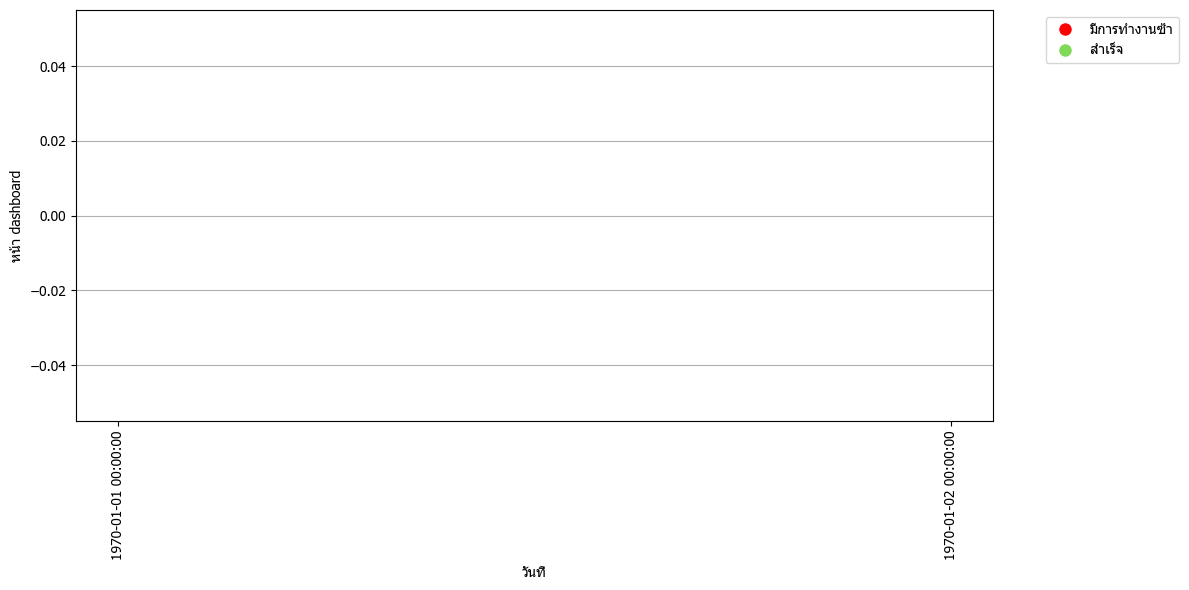

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

# Assuming df is your DataFrame containing the necessary columns

# Convert the 'created_at_local' column to a datetime type
df['created_at_local'] = pd.to_datetime(df['created_at_local'])

# Filter the DataFrame to include "Error" and "Success" status
error_df = df[df['status_job'] == 'failure']  # Assuming 'failure' corresponds to 'Error'
success_df = df[df['status_job'] == 'success']  # Assuming 'success' corresponds to 'Success'

# Create the scatter plot for "Error" status
plt.figure(figsize=(12, 6))
error_color = 'red'  # Color for "Error" data points
plt.scatter(error_df['created_at_local'], error_df['title'], c=error_color, label='มีการทำงานซ้ำ', alpha=0.5)

# Create the scatter plot for "Success" status
success_color = '#7ED957'  # Color for "Success" data points
plt.scatter(success_df['created_at_local'], success_df['title'], c=success_color, label='สำเร็จ', alpha=0.5)

# Customize the plot
plt.xlabel('วันที่')
plt.ylabel('หน้า dashboard')
plt.grid(axis='y')

plt.rcParams['font.family'] = 'Tahoma'

# Set the x-axis format to show ticks at 12-hour intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Adjusted to show ticks at daily intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=90)

# Define the custom legend using Line2D
custom_legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF0000', markersize=10, label='มีการทำงานซ้ำ'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#7ED957', markersize=10, label='สำเร็จ')
]

# Place the legend outside the plot
plt.legend(handles=custom_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of the legend
img_path = 'extract_fail'
plt.savefig(img_path,bbox_inches='tight')
plt.show()


In [88]:
df['Created At'] = pd.to_datetime(df['created_at_local'])

# Extracting the date with timestamp from the 'Created At' column
df['Date'] = df['Created At'].dt.floor('D')

# Creating the 'Success' and 'Error' columns based on 'Status of Job'
df['Success'] = df['status_job'].apply(lambda x: 1 if x == 'success' else 0)
df['Error'] = df['status_job'].apply(lambda x: 1 if x == 'error' else 0)

# Grouping by 'Date' and aggregating the counts
df2 = df.groupby('Date').agg({
    'Created At': 'first',  # Assuming you want to keep the first timestamp of the day
    'Success': 'sum',
    'Error': 'sum'
}).reset_index()
df2
# Renaming the columns as per your request
df2.rename(columns={'Created At': 'Created At per day'}, inplace=True)

# Convert the 'Date' column to datetime type
df2['Date'] = pd.to_datetime(df2['Date'])

# Converting the 'Date' column to Thai date format with Buddhist Era year
df2['Date'] = df2['Date'].apply(lambda x: f"{x.day}-{x.month}-{x.year + 543}")

# Drop the 'Created At per day' column
df2 = df2.drop(columns=['Created At per day'])

df2.rename(columns={'Date': 'วันที่'}, inplace=True)
df =df2
df

,วันที่,Success,Error


In [89]:
df['Created At'] = pd.to_datetime(df['created_at_local'])

# Extracting the date with timestamp from the 'Created At' column
df['Date'] = df['Created At'].dt.floor('D')

# Creating the 'Success' and 'Error' columns based on 'Status of Job'
df['Success'] = df['status_job'].apply(lambda x: 1 if x == 'success' else 0)
df['Error'] = df['status_job'].apply(lambda x: 1 if x == 'error' else 0)

# Grouping by 'Date' and aggregating the counts
df2 = df.groupby('Date').agg({
    'Created At': 'first',  # Assuming you want to keep the first timestamp of the day
    'Success': 'sum',
    'Error': 'sum'
}).reset_index()
df2
# Renaming the columns as per your request
df2.rename(columns={'Created At': 'Created At per day'}, inplace=True)

# Convert the 'Date' column to datetime type
df2['Date'] = pd.to_datetime(df2['Date'])

# Converting the 'Date' column to Thai date format with Buddhist Era year
df2['Date'] = df2['Date'].apply(lambda x: f"{x.day}-{x.month}-{x.year + 543}")

# Drop the 'Created At per day' column
df2 = df2.drop(columns=['Created At per day'])

df2.rename(columns={'Date': 'วันที่'}, inplace=True)
df =df2
df

KeyError: 'created_at_local'

# Extracts_bar (╯ ͡❛ ͜ʖ ͡❛)╯┻━┻

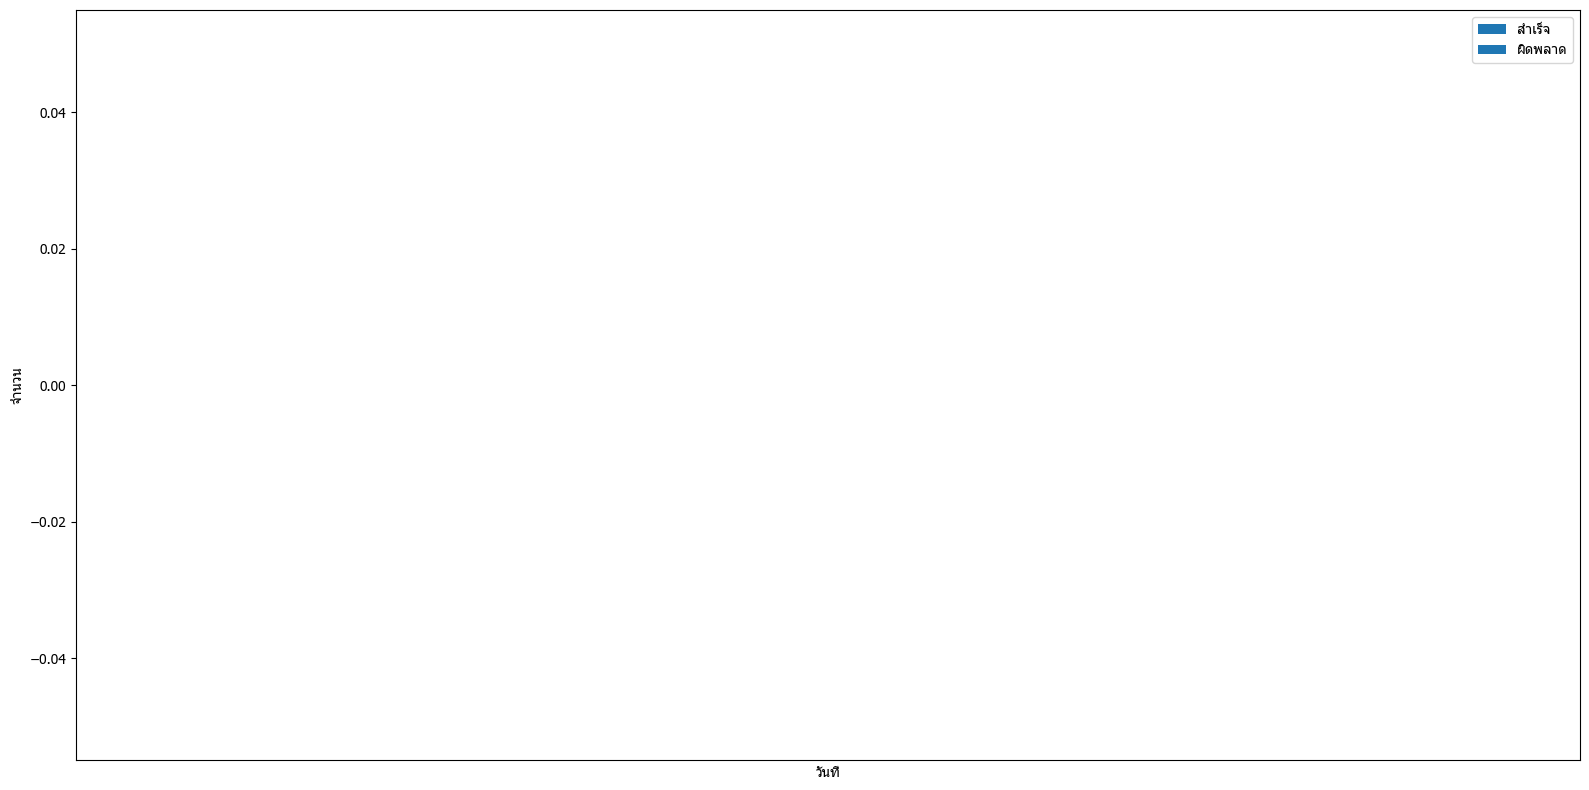

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# อ่านข้อมูลจากไฟล์ CSV
# json_file_path = r'C:\work_on_maholan\mhl-de-ma-report\json_file\Extracts_bar_m11.json'

# Read JSON file into DataFrame
# df = pd.read_json(json_file_path)
# df.fillna(0, inplace=True)

# แทนที่ค่า Error เป็น 0
df['Error'] = df['Error'].replace('0', 0)

# สร้างกราฟ
plt.figure(figsize=(16, 8))  # ปรับขนาดกราฟตามที่คุณต้องการ

# เพิ่ม grid
# plt.grid(True, linestyle='--', alpha=0.6)

# สร้างกราฟแท่งสแต็คบาร์
width = 0.5
x = range(len(df))
success_bars = plt.bar(x, df['Success'], width, label='สำเร็จ', color='g')
error_bars = plt.bar(x, df['Error'], width, label='ผิดพลาด', hatch='', color='red', bottom=df['Success'])

# ปรับแต่งกราฟ
plt.xlabel('วันที่')
plt.ylabel('จำนวน')
plt.rcParams['font.family'] = 'Tahoma'
plt.xticks(x, df['วันที่'], rotation='vertical')  # ปรับแต่งแกน x ให้เป็นแนวตั้ง
plt.legend()

# ระยะห่างด้านบนของกราฟ
top_padding = 1  # เพิ่มระยะห่างด้านบนไปอีก 3 นิ้ว

# แสดงค่า Success ภายในแต่ละแท่ง
# def add_labels(bars, top_padding=0):
#     for bar in bars:
#         height = bar.get_height()
#         plt.annotate(f'{int(height)}', (bar.get_x() + bar.get_width() / 2, height - top_padding), ha='center', va='bottom', fontsize=17)

# # เรียกใช้งานฟังก์ชันเพื่อแสดงค่า Success
# add_labels(success_bars, top_padding=top_padding)

# เพิ่มระยะห่างด้านบนสำหรับค่าผลรวม
top_sum = 1
# แสดงค่าผลรวมของ Success และ Error ด้านบนกราฟ
for i, (success, error) in enumerate(zip(df['Success'], df['Error'])):
    if pd.notna(success):  # ตรวจสอบว่าค่า Success ไม่ใช่ NaN
        total = success + error
        if pd.notna(total):  # ตรวจสอบว่าค่าผลรวมไม่ใช่ NaN
            # ใช้ int() หรือ str() เพื่อตัดทศนิยม .0
            plt.text(i, total + top_sum, str(int(total)), ha='center', va='bottom', fontweight='bold', fontsize=18)

# แสดงกราฟ
plt.tight_layout()  # ปรับระยะระหว่างกราฟ
img_path = 'extract_daily'
plt.savefig(img_path,bbox_inches='tight')
plt.show()


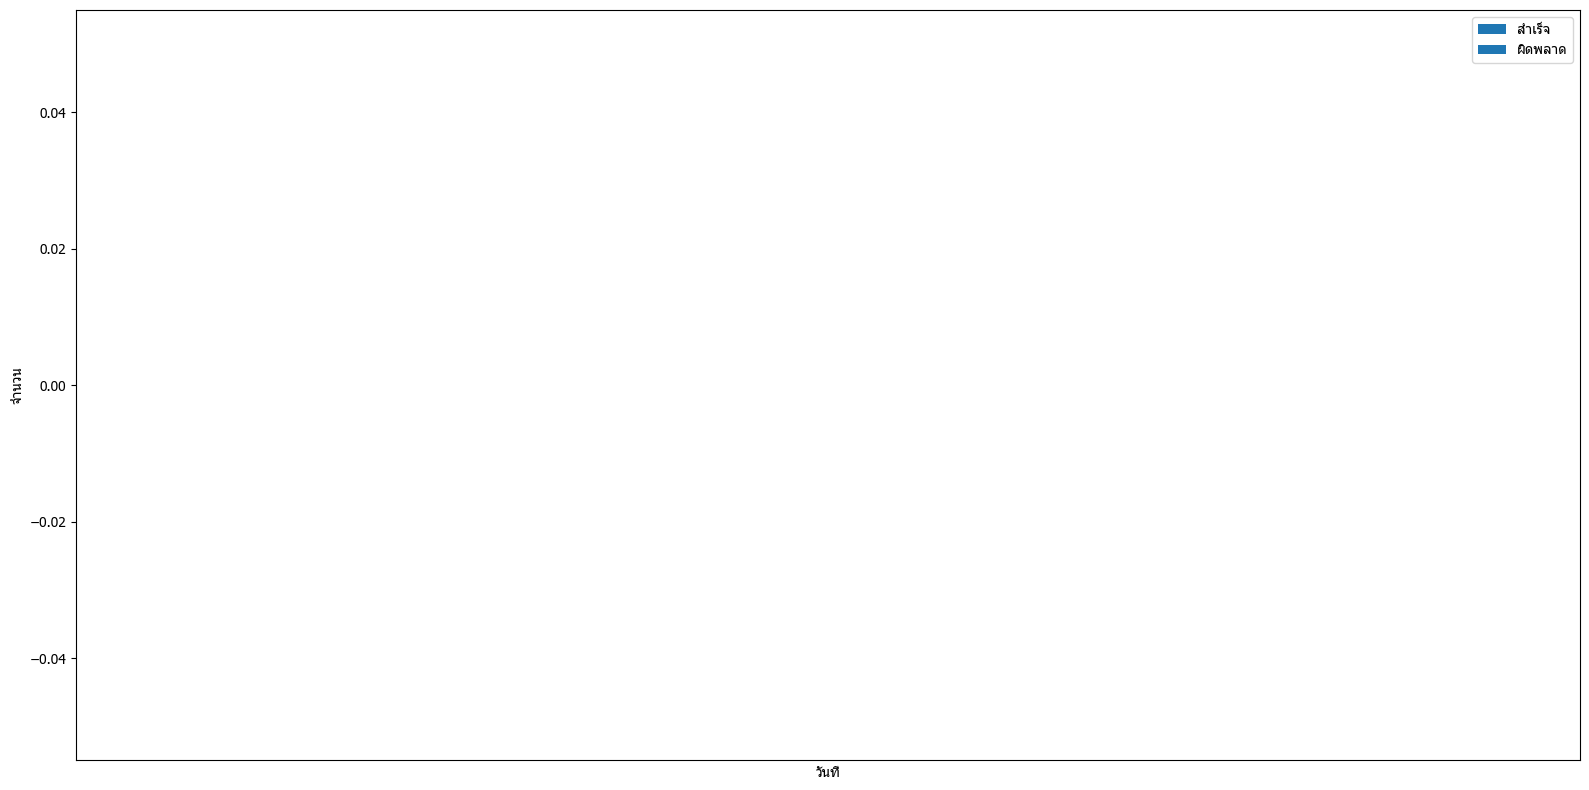

In [91]:
import pandas as pd
import matplotlib.pyplot as plt

# อ่านข้อมูลจากไฟล์ CSV


# แทนที่ค่า Error เป็น 0
df['Error'] = df['Error'].replace('0', 0)

# สร้างกราฟ
plt.figure(figsize=(16, 8))  # ปรับขนาดกราฟตามที่คุณต้องการ

# เพิ่ม grid
# plt.grid(True, linestyle='--', alpha=0.6)

# สร้างกราฟแท่งสแต็คบาร์
width = 0.5
x = range(len(df))
success_bars = plt.bar(x, df['Success'], width, label='สำเร็จ', color='g', bottom=df['Error'])
error_bars = plt.bar(x, df['Error'], width, label='ผิดพลาด', hatch='', color='red')

# ปรับแต่งกราฟ
plt.xlabel('วันที่')
plt.ylabel('จำนวน')
plt.rcParams['font.family'] = 'Tahoma'
plt.xticks(x, df['วันที่'], rotation='vertical')  # ปรับแต่งแกน x ให้เป็นแนวตั้ง
plt.legend()

# ระยะห่างด้านบนของกราฟ
top_padding = 1  # เพิ่มระยะห่างด้านบนไปอีก 3 นิ้ว

# แสดงค่า Success ภายในแต่ละแท่ง
def add_labels(bars, top_padding=0):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{int(height)}', (bar.get_x() + bar.get_width() / 2, height - top_padding), ha='center', va='top', fontsize=17)

def add_labels(bars, top_padding=0):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{int(height)}', (bar.get_x() + bar.get_width() / 2, height - top_padding), ha='center', va='bottom', fontsize=17)

# เรียกใช้งานฟังก์ชันเพื่อแสดงค่า Success
add_labels(success_bars, top_padding=top_padding)
add_labels(error_bars, top_padding=top_padding)

# เพิ่มระยะห่างด้านบนสำหรับค่าผลรวม
top_sum = 0
# แสดงค่าผลรวมของ Success และ Error ด้านบนกราฟ
for i, (success, error) in enumerate(zip(df['Success'], df['Error'])):
    if pd.notna(success):  # ตรวจสอบว่าค่า Success ไม่ใช่ NaN
        total = success + error
        if pd.notna(total):  # ตรวจสอบว่าค่าผลรวมไม่ใช่ NaN
            # ใช้ int() หรือ str() เพื่อตัดทศนิยม .0
            plt.text(i, total + top_sum, str(int(total)), ha='center', va='bottom', fontweight='bold', fontsize=18)

# แสดงกราฟ
plt.tight_layout()  # ปรับระยะระหว่างกราฟ
plt.show()


# Most view dashboard (╯ ͡❛ ͜ʖ ͡❛)╯┻━┻

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Specify the URL to fetch JSON data
url = os.getenv('REPORT_SERVICE')+f"tableau/top5_histview?month={month}&year={year}" #"http://localhost:1234/report-service/api/v1/tableau/Top5_View_Dashboard?month=12&year=2023"
auth_token = os.getenv('AUTH_TOKEN')
# Add Bearer token to the request headers
headers = {
    'Authorization': f'{auth_token}',  # Replace '1234' with your actual token
}

# Fetch JSON data from the URL with headers
response = requests.get(url, headers=headers)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    json_data = response.json()
    
    # Extract the 'data' key from the JSON data
    data_list1 = json_data.get('total_runs', {}).get('data', [])

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data_list1)
# สร้างกราฟแนวนอน
# สร้างกราฟแนวนอน
plt.figure(figsize=(10, 6))
plt.barh(df['title'], df['view_count'], color='skyblue')
plt.xlabel('จำนวนที่เข้าดู')
plt.ylabel('หน้า Dashboard')
plt.gca().invert_yaxis()  # เรียงลำดับจากมากไปน้อย

# ปรับแต่งคำอธิบายด้านข้างของกราฟ
for i, count in enumerate(df['view_count']):
    plt.text(count, i, f' {count}', va='center')
# plt.savefig('top_5_views.png')
ax.invert_yaxis()

# ax.set_title('Load time of top 10 most view dashboards')
ax.grid()
# ax.get_axisbelow()
img_path = 'top5_dashboard_view'
plt.savefig(img_path,bbox_inches='tight')
plt.show()


KeyError: 'title'

<Figure size 1000x600 with 0 Axes>

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Specify the URL to fetch JSON data
url = os.getenv('REPORT_SERVICE') + 'tableau/database_connection' #"http://localhost:1234/report-service/api/v1/tableau/Top5_View_Dashboard?month=12&year=2023"
auth_token = os.getenv('AUTH_TOKEN')
# Add Bearer token to the request headers
headers = {
    'Authorization': f'Bearer {auth_token}',  # Replace '1234' with your actual token
}

# Fetch JSON data from the URL with headers
response = requests.get(url, headers=headers)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    json_data = response.json()
    
    # Extract the 'data' key from the JSON data
    data_list1 = json_data.get('data', [])

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data_list1)
data_source_by_dashboard_sum = df.to_dict(orient='record')


# top5 workbook


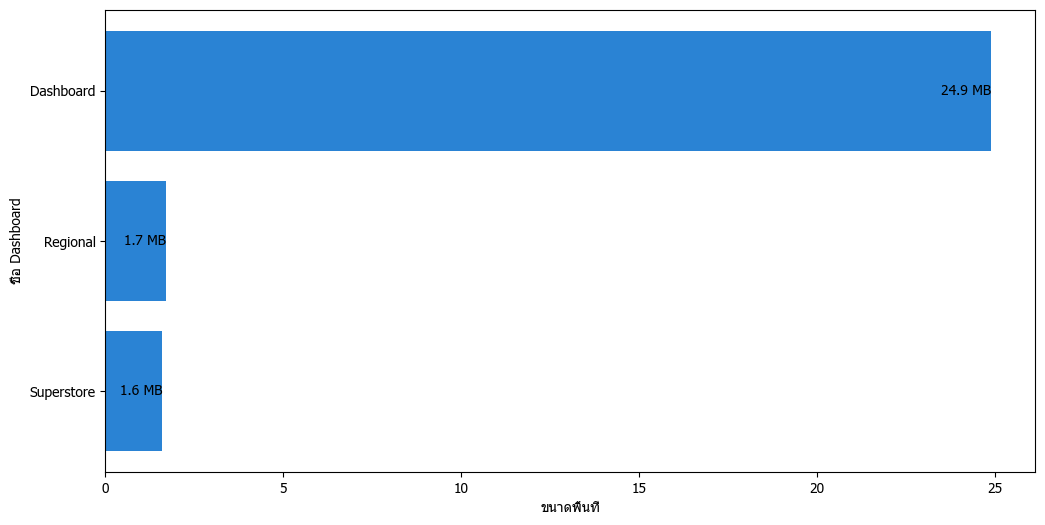

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

# ระบุ path ของไฟล์ CSV
url = os.getenv('REPORT_SERVICE') + 'tableau/top5_space_by_workbook'
auth_token = os.getenv('AUTH_TOKEN')
# Add Bearer token to the request headers
headers = {
    'Authorization': f'{auth_token}',  # Replace '1234' with your actual token
}

# Fetch JSON data from the URL with headers
response = requests.get(url, headers=headers)

if response.status_code == 200:
    json_data = response.json()
    
    # Extract the 'data' key from the JSON data
    data_list1 = json_data['data']

    # Create a DataFrame from the list of dictionaries
    data = pd.DataFrame(data_list1)

# เรียงลำดับข้อมูลตามคอลัมน์ 'size' จากมากไปน้อย
data = data.sort_values(by='size in MB', ascending=False)

# กำหนด y เป็นคอลัมน์ Name และ x เป็นคอลัมน์ size สำหรับ 10 รายการแรก
y = data['name_workbook'][:10]
x = data['size in MB'][:10]
plt.rcParams['font.family'] = 'Tahoma'

# กำหนดสีของแท่งที่ต้องการให้เป็นสีฟ้าเข้ม
colors = [ '#2A83D4','#2A83D4', '#2A83D4','#2A83D4', '#2A83D4','#2A83D4',  '#2A83D4',  '#2A83D4','#2A83D4','#2A83D4']

# กำหนดขนาดของกราฟ (เช่น, ขนาดกว้างเพิ่มเติมเป็น 12 นิ้ว)
plt.figure(figsize=(12, 6))

# สร้างกราฟแท่งแนวนอนและกำหนดสีตามลำดับ
plt.barh(y, x, color=colors)

# เพิ่มค่า size พร้อมกับหน่วย MB ในแต่ละแท่ง
for i, v in enumerate(x):
    # เลื่อนค่า size ไปด้านซ้ายของแต่ละแท่ง
    plt.text(v, i, f'{v} MB', color='black', va='center', ha='right')

# กำหนดชื่อแกน
plt.xlabel('ขนาดพื้นที่')
plt.ylabel('ชื่อ Dashboard')

# เรียงลำดับแท่งจากมากไปน้อย
plt.gca().invert_yaxis()
img_path = 'the_most_datalytics64'
plt.savefig(img_path,bbox_inches='tight')
# แสดงกราฟ
plt.show()

In [ ]:
doc = DocxTemplate
context = {
'Datasources_by Dashboard_Summary': data_source_by_dashboard_sum, #ss
'Tableau_Server_Disk_Space': InlineImage(doc,"./tableau/Tableau_Server_Disk_Space.png",width=Cm(16)), #ss
'the_most_datalytics64': InlineImage(doc,"./tableau/the_most_datalytics64.png",width=Cm(16)), #ss
'extract_daily' :InlineImage(doc,"./tableau/extract_daily.png",width=Cm(16)), 
'extract_fail' : InlineImage(doc,"./tableau/extract_daily.png",width=Cm(16)), 
'dashboard_performance' : InlineImage(doc,"./tableau/dashboard_performance.png",width=Cm(16)), 
'top5_dashboard_view': InlineImage(doc,"./tableau/top5_dashboard_view.png",width=Cm(16)), #ss
'tableau_server_by_project': InlineImage(doc,"./tableau/tableau_server_by_project.png",width=Cm(16)) #ss    
    }

def get_auditrail() :
    # print(context)
    return context